In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_fwf('./wili dataset/x_train.txt', header=None)
X_train = df[[0]]
df = pd.read_fwf('./wili dataset/x_test.txt', header=None)
X_test = df[[0]] 

In [3]:
target = pd.read_fwf('./wili dataset/y_train.txt',header = None)
y_train = target[[0]]
target = pd.read_fwf('./wili dataset/y_test.txt',header = None)
y_test = target[[0]]

In [4]:
y_train[y_train == 'be-tara'] = 'be-tarask'
y_train[y_train == 'roa-tar'] = 'roa-tara'

In [5]:
languages = ['eng', 'hin', 'mar', 'guj', 'tam', 'tcy', 'tel', 'pan', 'ben', 'mai']

In [6]:
train_index = y_train.index[y_train[0].isin(languages)].tolist()

In [7]:
test_index = y_test.index[y_test[0].isin(languages)].tolist()

In [8]:
X_train_p = X_train.iloc[train_index,:]
X_test_p = X_test.iloc[test_index,:]

In [9]:
y_train_p = y_train.iloc[train_index, :]
y_test_p = y_test.iloc[test_index, :]

### Tokenize Labels

In [10]:
label2int = {}
counter = 0
for label in languages:
    if label not in label2int:
        label2int[label] = counter
    counter += 1

### Tokenize target Variables

In [11]:
y_train_int = []
for label in y_train_p[0]:
    y_train_int.append(label2int[label])

In [12]:
y_test_int = []
for label in y_test_p[0]:
    y_test_int.append(label2int[label])

### Data Preprocessing

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer(analyzer='char',min_df=25,lowercase=True, norm='l2')

In [15]:
vectorizer.fit(X_train_p[0])

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=25,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
X_train2int = vectorizer.transform(X_train_p[0]).toarray()

In [17]:
X_test2int = vectorizer.transform(X_test_p[0]).toarray()

### Scaler

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
sc = StandardScaler()

In [20]:
sc.fit(X_train2int)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
X_train2int_sc = sc.transform(X_train2int)
X_test2int_sc = sc.transform(X_test2int)

### PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=80)

In [24]:
pca.fit(X_train2int_sc)

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
X_train_pca = pca.transform(X_train2int_sc)

In [26]:
X_test_pca = pca.transform(X_test2int_sc)

In [27]:
import matplotlib.pyplot as plt

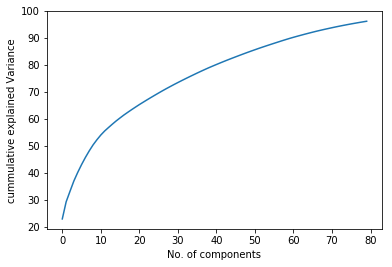

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

### One Hot Encoding

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
y_train_int = np.array(y_train_int).reshape(-1, 1)
y_test_int = np.array(y_test_int).reshape(-1, 1)

In [32]:
enc = OneHotEncoder()

In [34]:
enc.fit(y_train_int)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [35]:
y_train_enc = enc.transform(y_train_int)
y_test_enc = enc.transform(y_test_int)

## Design ANN

In [62]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [64]:
clf = Sequential()
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu', input_dim = 80))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 60, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim = 130, kernel_initializer = 'uniform', activation='relu'))
clf.add(Dropout(rate=0.2))
clf.add(Dense(output_dim =10  , kernel_initializer = 'uniform', activation='softmax'))

C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=80, units=60)`
  
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=60)`
  after removing the cwd from sys.path.
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=130)`
  
C:\Users\Jatin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="softmax", units=10)`
  


In [65]:
clf.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [66]:
with tf.device('/gpu:0'):
    history = clf.fit(X_train_pca, y_train_enc, batch_size=16, epochs=100, validation_data=(X_test_pca,y_test_enc))

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 2s 382us/step - loss: 0.7606 - acc: 0.7690 - val_loss: 0.1566 - val_acc: 0.9596
Epoch 2/100
5000/5000 [==============================] - 2s 316us/step - loss: 0.1597 - acc: 0.9604 - val_loss: 0.1524 - val_acc: 0.9622
Epoch 3/100
5000/5000 [==============================] - 2s 311us/step - loss: 0.1300 - acc: 0.9682 - val_loss: 0.1491 - val_acc: 0.9634
Epoch 4/100
5000/5000 [==============================] - 2s 312us/step - loss: 0.1230 - acc: 0.9684 - val_loss: 0.1428 - val_acc: 0.9630
Epoch 5/100
5000/5000 [==============================] - 2s 318us/step - loss: 0.1160 - acc: 0.9690 - val_loss: 0.1622 - val_acc: 0.9630
Epoch 6/100
5000/5000 [==============================] - 2s 317us/step - loss: 0.1067 - acc: 0.9734 - val_loss: 0.1574 - val_acc: 0.9644
Epoch 7/100
5000/5000 [==============================] - 2s 314us/step - loss: 0.1025 - acc: 0.9710 - val_loss: 0.1635 - val_acc: 

5000/5000 [==============================] - 2s 310us/step - loss: 0.0381 - acc: 0.9890 - val_loss: 0.2573 - val_acc: 0.9648
Epoch 61/100
5000/5000 [==============================] - 2s 310us/step - loss: 0.0392 - acc: 0.9870 - val_loss: 0.2716 - val_acc: 0.9640
Epoch 62/100
5000/5000 [==============================] - 2s 309us/step - loss: 0.0309 - acc: 0.9904 - val_loss: 0.2641 - val_acc: 0.9614
Epoch 63/100
5000/5000 [==============================] - 2s 310us/step - loss: 0.0392 - acc: 0.9880 - val_loss: 0.2725 - val_acc: 0.9606
Epoch 64/100
5000/5000 [==============================] - 2s 310us/step - loss: 0.0404 - acc: 0.9880 - val_loss: 0.2658 - val_acc: 0.9622
Epoch 65/100
5000/5000 [==============================] - 2s 310us/step - loss: 0.0413 - acc: 0.9884 - val_loss: 0.2435 - val_acc: 0.9638
Epoch 66/100
5000/5000 [==============================] - 2s 310us/step - loss: 0.0340 - acc: 0.9906 - val_loss: 0.2489 - val_acc: 0.9606
Epoch 67/100
5000/5000 [=======================

## Evaluation

In [67]:
y_pred_test_label = clf.predict(X_test_pca)
y_pred_train_label = clf.predict(X_train_pca)

In [68]:
y_pred_test = np.argmax(y_pred_test_label, axis=1)
y_pred_train = np.argmax(y_pred_train_label, axis=1)

In [69]:
y_train_true = y_train_int.astype(np.int)
y_test_true = y_test_int.astype(np.int)

## Graph Plot

### Model Accuracy Graph

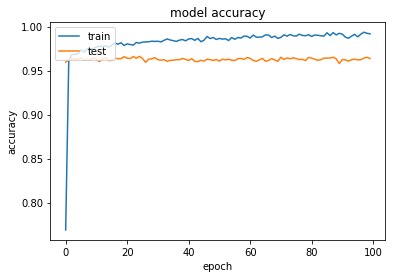

In [70]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Loss Graph

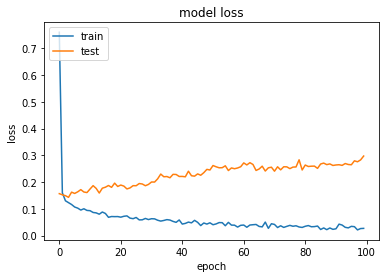

In [71]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Classification Report

In [72]:
from sklearn.metrics import classification_report

#### Train Data report

In [73]:
print(classification_report(y_train_true, y_pred_train))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       500
          1       1.00      1.00      1.00       500
          2       1.00      1.00      1.00       500
          3       1.00      0.99      0.99       500
          4       1.00      1.00      1.00       500
          5       1.00      1.00      1.00       500
          6       1.00      1.00      1.00       500
          7       1.00      1.00      1.00       500
          8       1.00      1.00      1.00       500
          9       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      5000



#### Test Data Report

In [74]:
print(classification_report(y_test_true, y_pred_test))

             precision    recall  f1-score   support

          0       0.83      0.97      0.89       500
          1       0.97      0.93      0.95       500
          2       0.95      0.96      0.96       500
          3       0.99      0.97      0.98       500
          4       1.00      0.98      0.99       500
          5       0.99      1.00      0.99       500
          6       0.98      0.95      0.96       500
          7       1.00      0.98      0.99       500
          8       0.98      0.95      0.97       500
          9       0.97      0.94      0.96       500

avg / total       0.97      0.96      0.96      5000



## Confusion Matrix

In [75]:
from sklearn.metrics import confusion_matrix

### Train data

In [76]:
print(confusion_matrix(y_pred_train, y_train_true))

[[500   0   2   5   0   0   1   1   2   1]
 [  0 500   0   0   0   0   0   0   0   1]
 [  0   0 498   0   0   0   0   0   0   0]
 [  0   0   0 495   0   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0]
 [  0   0   0   0   0 500   0   0   0   0]
 [  0   0   0   0   0   0 499   0   0   0]
 [  0   0   0   0   0   0   0 499   0   0]
 [  0   0   0   0   0   0   0   0 498   0]
 [  0   0   0   0   0   0   0   0   0 498]]


### Test data

In [77]:
print(confusion_matrix(y_pred_test, y_test_true))

[[483   8  14  16   4   0  24   6  16  12]
 [  0 467   1   0   0   0   0   0   1  11]
 [  2  15 479   0   1   0   0   0   1   4]
 [  2   0   0 484   0   0   0   0   1   0]
 [  1   0   0   0 492   0   0   1   0   0]
 [  0   0   0   0   1 500   2   0   2   1]
 [  8   1   0   0   0   0 473   0   0   0]
 [  0   0   0   0   0   0   1 492   0   0]
 [  4   1   1   0   2   0   0   0 477   0]
 [  0   8   5   0   0   0   0   1   2 472]]
